# X-ray diffraction pattern segmentation on 44Mn steel

### Scientific Background

Microalloyed steel (as many other types of steel and iron) has a ferritic crystal structure at low temperatures and an austenitic structure at high temperatures. The exact point can vary with the composition. If we now penetrate a specimen with X-Rays, the rays diffracted by the material form distinct circular patterns on a detector depending on the crystal structure. Conversely, the structure can be determined from the measured patterns.
For a high-temperature deformation experiment, a specimen was heated from 20 C to 1300 C, deformed and cooled back to 20 C. Diffraction patterns were acquired throughout the experiment and we need to determine the crystal structure for each to investigate at which temperature changes occur and if the deformation has any effect.

### Why Machine Learning?

The dataset contains 20 experiments with around 24000 images each, amounting to around one Terabyte of 2D image data. Instead of manually classifying them, we can use simple convolutional neural networks and train them on a small set of 50 images, reducing the prediction time to 25 min in total.

### Data format and preparation

Per crystal structure, austenite and ferrite, 25 diffraction images were moved into respective folders for training and validation.

Data format of tomograms: 32b float greyscale cbf images, 1679 x 1475 pixel

Example of an austenitic pattern:

<img src="https://raw.githubusercontent.com/Tiwi68/DRX_classification/main/44Mn_S6_t1_04360_scaled.jpg" width="369" height="420">

### Set up

Import dependencies:

In [18]:
import tensorflow as tf
import numpy as np
import fabio
import os
import sys
import sklearn
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

#save standard output device, as it is switched later. The cbf import library FabIO is persistently verbose.
old_stdout = sys.stdout

### Generator

This generator feeds single images to the model. The inputs are the directories of both training image classes, the image size to shrink to and an option to shuffle the input images.
CBF files are loaded using FabIO, which permanently verbalises its activities. The print output is hence temporarily directed to a null device every time FabIO runs.

To get one probability value per class, the binary label is one-hot encoded.

In [2]:
def cbf_generator(class_0_dir, class_1_dir, image_size, shuffle=False):
    
    # create array of filenames and classes derived from their directory
    filenames = np.array(os.listdir(class_0_dir) + os.listdir(class_1_dir))
    labels = np.zeros(len(filenames)).astype('int')
    labels[len(os.listdir(class_0_dir)):] = 1
    
    # shuffle filename-class pairs if required
    if shuffle == True:
        filenames, labels = sklearn.utils.shuffle(filenames, labels)
        
    #repeat file load and processing infinitely to keep up data supply for all epochs
    while True:
        for filename, label in zip(filenames, labels):
            
            # concatenate full file path depending on class
            if label == 0:
                path = class_0_dir + '/' + filename  
            elif label == 1:
                path = class_1_dir + '/' + filename
            
            #silence fabio output
            sys.stdout = open(os.devnull, "w")
            
            # open file
            with fabio.open(path) as cbffile:
                image = Image.fromarray(cbffile.data)
                
                #enable output again
                sys.stdout = old_stdout
                
                #resize image, convert to array, normalise and add dimension
                image = np.asarray(image.resize((image_size, image_size),
                                                 Image.NEAREST)).astype('float32')
                
                #standardise greyscale values and expand dimensions by 1 for greyscale channel
                image = (image - np.mean(image))/np.std(image)
                image = np.expand_dims(np.expand_dims(image, -1), 0)
                
                # one-hot encode the classes
                label_cat = tf.keras.utils.to_categorical(label, 2)
                
                yield image, np.asarray([label_cat])
            
            #enable output again - doing it only once is not reliable
            sys.stdout = old_stdout
        sys.stdout = old_stdout
    sys.stdout = old_stdout

### Model

Set up hyperparameters and generators for training and validation. A learning rate of 0.00001 was found to perform well by previously testing the model on various rates.

In [3]:
image_size = 512 # shrink images to this size
learning_rate = 0.00001
epochs = 7

train_files = len(
    os.listdir('C:/Users/Tim/Desktop/diffclass/cbf_train/ferrite')) + len(
        os.listdir('C:/Users/Tim/Desktop/diffclass/cbf_train/austenite'))
val_files = len(
    os.listdir('C:/Users/Tim/Desktop/diffclass/cbf_val/ferrite')) + len(
        os.listdir('C:/Users/Tim/Desktop/diffclass/cbf_val/austenite'))
        
train_gen = cbf_generator(
        'C:/Users/Tim/Desktop/diffclass/cbf_train/ferrite',
        'C:/Users/Tim/Desktop/diffclass/cbf_train/austenite',
        image_size=image_size,
        shuffle = True)

val_gen = cbf_generator(
        'C:/Users/Tim/Desktop/diffclass/cbf_val/ferrite',
        'C:/Users/Tim/Desktop/diffclass/cbf_val/austenite',
        image_size=image_size)

Define the model using the Keras functional API (a sequential model would have done). Three convolution levels are sufficient before feeding the weights into a two-node dense layer, again to get one probability value per class. Separable convolutions seem to speed the training up.

In [4]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(image_size, image_size, 1))
x = inputs

x = tf.keras.layers.SeparableConv2D(16, 3, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

x = tf.keras.layers.SeparableConv2D(32, 3, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

x = tf.keras.layers.SeparableConv2D(64, 3, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)

x = tf.keras.layers.Flatten()(x)

# Output layer with classification
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

#instantiate model
model = tf.keras.Model(inputs, outputs)

Select optimiser and compile model for categorical classification, as I want one probability value per class as output.

In [5]:
opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=(['accuracy']))

print('learning rate', learning_rate)
print('fitting model')

learning rate 1e-05
fitting model


Train the model, save the final result and gather the training metrics in a dictionary. No intermediate weights are saved as training is fast.

In [8]:
history = model.fit(train_gen, steps_per_epoch=train_files, epochs=epochs,
                    validation_data=val_gen, validation_steps=val_files,
                    shuffle=False, verbose=2)

model.save('best_class_model.h5')

#gather metrics
metrics_dict = {'learning rate': learning_rate,
                'train_loss': history.history['loss'],
                'val_loss': history.history['val_loss'],
                'train_accuracy': history.history['accuracy'],
                'val_accuracy': history.history['val_accuracy']}


Epoch 1/7


59/59 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.8218e-08 - val_accuracy: 1.0000
Epoch 2/7
59/59 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.2674e-08 - val_accuracy: 1.0000
Epoch 3/7
59/59 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.9902e-08 - val_accuracy: 1.0000
Epoch 4/7
59/59 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.7129e-08 - val_accuracy: 1.0000
Epoch 5/7
59/59 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.8812e-08 - val_accuracy: 1.0000
Epoch 6/7
59/59 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.6040e-08 - val_accuracy: 1.0000
Epoch 7/7
59/59 - 2s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 3.3268e-08 - val_accuracy: 1.0000


Plot the training history:

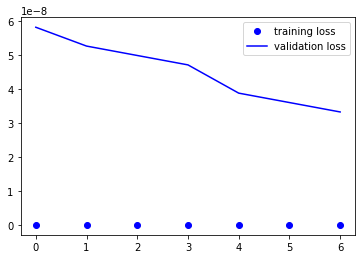

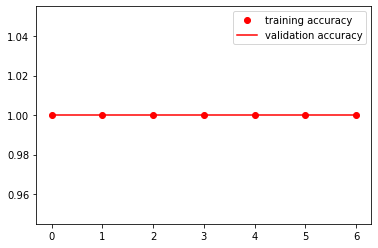

In [9]:
plt.plot(range(len(history.history['loss'])), history.history['loss'],
         'bo', label='training loss')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'],
         'b', label='validation loss')
plt.legend()
plt.figure()
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'],
         'ro', label='training accuracy')
plt.plot(range(len(history.history['accuracy'])), history.history['val_accuracy'],
         'r', label='validation accuracy')
plt.legend()

#### It looks like the model is overkill for the task, we immediately hit accuracy = 1 on the small validation dataset. I am considering a simpler model, e.g. kNN or SVM.

### Prediction

Set up a generator similar to above predicting all patterns in a folder, e.g. for one experiment. The option of subsampling filenames can accelerate the output.

In [13]:
#%% predict

#subsampling: pick every n-th file
n = 1

def pred_generator(directory, image_size):
    
    filenames = np.array(os.listdir(directory))
    
    #repeat infinitely to keep up data supply for all epochs
    for filename in filenames[::n]:
        
        path = directory + '/' + filename
        #print(path) #if desired
        
        #silence fabio output
        sys.stdout = open(os.devnull, "w")
        with fabio.open(path) as cbffile:
            image = Image.fromarray(cbffile.data)
            #enable output again
            sys.stdout = old_stdout
            
            #resize image, convert to array, normalise and add dimension
            image = np.asarray(image.resize((image_size, image_size),
                                             Image.NEAREST)).astype('float32')
            image = (image - np.mean(image))/np.std(image)
            image = np.expand_dims(np.expand_dims(image, -1), 0)
            
            yield image
        
        #enable output again
        sys.stdout = old_stdout
    sys.stdout = old_stdout


Run and print predictions:

In [19]:
pred_gen = pred_generator(
    'C:/Users/Tim/Desktop/diffclass/44Mn_S6',
    image_size=image_size)

print(datetime.now())
prediction = model.predict(pred_gen)
print(prediction)
print(datetime.now())

2021-01-22 16:34:33.981442
[[1.0000000e+00 2.4377240e-09]
 [1.0000000e+00 2.4072200e-09]
 [1.0000000e+00 2.4469711e-09]
 ...
 [6.3039279e-01 3.6960724e-01]
 [5.7924509e-01 4.2075488e-01]
 [7.0099807e-01 2.9900193e-01]]
2021-01-22 16:35:47.193788


Classifying all 24000 images of this experiment takes only 1 minute and 13 seconds.

Temperatures and timestamps measured by a separate device need to be aligned with the images.

In [16]:
# Temperature measurment and imaging were started a few seconds apart and need to be zeroised
timeshift = 143.1605 - 133.892

#load temperature log with timestamps into dataframe
templog_path = 'E:/mg23749-1/processing/MG23749_ETMT_Logs/HSSF_44Mn_S6_Trial1/44Mn_S6_t1_ETMT_log.xlsx'
templog = pd.read_excel(templog_path, sheet_name='Test1.steps.tracking',
                        header=0, usecols = 'A,M')
templog = templog.rename(columns={'Total Time (s)': 'time',
                        'User-Defined(Temperature:Temperature) (C)': 'temp C'})#.sort_values('time')

#align temperature timestamps to imaging timestamps
templog['time'] = templog['time'] - timeshift

#load imaging log with timestamps into dataframe
imglog_path = 'E:/mg23749-1/rawdata/44Mn_S6_trial1_0.006Acq_0.003Exp_2019_12_05-230520/pilatus_00001.log'
imglog = pd.read_csv(imglog_path, sep='\t', header=None, skiprows=1, usecols=[5, 6])
imglog = imglog.dropna(axis=0)
imglog = imglog.rename(columns={5: 'filename', 6: 'time'})#.sort_values('time')

#merge temperature and imaging logs on the nearest time values
bothlog = pd.merge_asof(imglog, templog, on='time') #retaining imglog numbering
bothlog = bothlog.dropna(axis=0)
bothlog['filenr'] = bothlog['filename'].str[-9:-4]

#get list of predicted file numbers from filenames
filenames = np.array(os.listdir('C:/Users/Tim/Desktop/diffclass/44Mn_S6'))
filenumbers = []
for filename in filenames[::n]:
    filenumbers.append(''.join(list(filename)[-9:-4]))
filenumbers = pd.DataFrame(filenumbers).rename(columns={0: 'filenr'})

#merge filenumbers with both logs to get full dataset
fn_logs_merged=filenumbers.merge(bothlog, on='filenr', how='left')

Plot the ratio of ferrite, austenite and the temperature versus the elapsed experimental time:

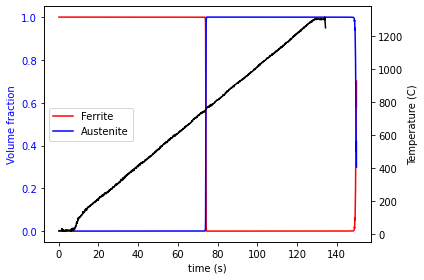

In [17]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time (s)')
ax1.set_ylabel('Volume fraction', color='b')
plt.plot(fn_logs_merged['time'], prediction[:,0],
         'r', label='Ferrite')
plt.plot(fn_logs_merged['time'], prediction[:,1],
         'b', label='Austenite')
plt.legend()
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Temperature (C)', color='k')  # we already handled the x-label with ax1
plt.plot(fn_logs_merged['time'][:-260], fn_logs_merged['temp C'][:-260],
         'k', label='T (C)')
ax2.tick_params(axis='y', labelcolor='k')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


At low temperatures we see pure ferrite, at high temperatures pure austenite. The phase change temperature can be found on the right scale as the point where crystal structures and temperature cross, at about 750 C. It is also evident that the deformation, during the flat temperature range on the top right, does not affect the crystal structure.